# Confronto tra HGCN e GCN su un albero bilanciato senza usare features dei nodi

In [1]:
import os
import re
import matplotlib.pyplot as plt

stampa = False

def print_metrics(log, p=True):

    # Regex per estrarre i valori dalle righe nei log dei risultati prodotti dalla libreria 
    re_train = re.compile(
        r"Epoch:\s*(\d+).*?train_loss:\s*([0-9.]+)\s*train_roc:\s*([0-9.]+)\s*train_ap:\s*([0-9.]+)"
    )

    # Regex per righe di validation
    re_val = re.compile(
        r"Epoch:\s*(\d+).*?val_loss:\s*([0-9.]+)\s*val_roc:\s*([0-9.]+)\s*val_ap:\s*([0-9.]+)"
    )

    # Regex valori finali test
    re_test = re.compile(
        r"Test set results:\s*test_loss:\s*([0-9.]+)\s*test_roc:\s*([0-9.]+)\s*test_ap:\s*([0-9.]+)"
    )

    train_loss, train_roc, train_ap = [], [], []
    val_loss, val_roc, val_ap = [], [], []
    test_loss = test_roc = test_ap = 0.0

    with open(log, "r") as f:
        for line in f:
            m = re_train.search(line)
            if m:
                train_loss.append(float(m.group(2)))
                train_roc.append(float(m.group(3)))
                train_ap.append(float(m.group(4)))

            m = re_val.search(line)
            if m:
                val_loss.append(float(m.group(2)))
                val_roc.append(float(m.group(3)))
                val_ap.append(float(m.group(4)))

            m = re_test.search(line)
            if m:
                test_loss = float(m.group(1))
                test_roc  = float(m.group(2))
                test_ap   = float(m.group(3))

    epochs = list(range(1, len(train_loss)+1))
    if p :

        # ------------ GRAFICO TRAIN LOSS -------------------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()

        # ------------ GRAFICO TRAIN ROC + AP ---------------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_roc, label="train_roc")
        plt.plot(epochs, val_roc,  label="val_roc")
        plt.title("Curva ROC")
        plt.xlabel("Epoch")
        plt.ylabel("ROC")
        plt.legend()
        plt.grid()
        plt.show()

        # ------------ GRAFICO VALIDATION ROC + AP ----------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_ap, label="train_ap")
        plt.plot(epochs, val_ap,  label="val_ap")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Acc")
        plt.legend()
        plt.grid()
        plt.show()

        # ------------ TEST RESULTS -----------------
    print("Test metrics finali:")
    print(f"  test_loss = {test_loss}")
    print(f"  test_roc  = {test_roc}")
    print(f"  test_ap   = {test_ap}")
    return train_roc, train_ap, val_roc, val_ap, test_roc, test_ap

def stampa_barre(dati, steps, stamp, C):
    labels = []
    for i in steps:
        labels.append(str(int(i*100))+"%")
    
    fig, axes = plt.subplots(1, 3, figsize=(C*3, C))  # 1 riga, 2 colonne

    # ===== PRIMO GRAFICO (media_roc) =====
    data = dati[0]
    x = list(data.keys())
    y = list(data.values())

    bars = axes[0].bar(x, y, width=1.0, color=colors)

    for bar in bars:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

    axes[0].axhline(0.5, color='red', linestyle='--', alpha=0.8)
    axes[0].set_xticks(x)
    axes[0].set_ylim(0, 1)
    axes[0].set_xticklabels(labels)
    axes[0].set_title('Media '+stamp)

    # ===== SECONDO GRAFICO (mediana_roc) =====
    data = dati[1]
    x = list(data.keys())
    y = list(data.values())

    bars = axes[1].bar(x, y, width=1.0, color=colors)

    for bar in bars:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

    axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.8)
    axes[1].set_xticks(x)
    axes[1].set_ylim(0, 1)
    axes[1].set_xticklabels(labels)
    axes[1].set_title('Mediana '+stamp)

    # ===== TERZO GRAFICO (mediana_roc) =====
    data = dati[2]
    x = list(data.keys())
    y = list(data.values())

    bars = axes[2].bar(x, y, width=1.0, color=colors)

    for bar in bars:
        height = bar.get_height()
        axes[2].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

    axes[2].axhline(0.5, color='red', linestyle='--', alpha=0.8)
    axes[2].set_xticks(x)
    axes[2].set_ylim(0, 1)
    axes[2].set_xticklabels(labels)
    axes[2].set_title('Moda '+stamp)

    plt.tight_layout()
    plt.show()

special = ["(lr 0.001, dim2)", "lr 0.00005", "lr 0.0005", "lr 0.005", "lr 0.01", "lr 0.05", "lr 0.09", "lr 0.12", "dim3", "dim4", "dim8", "dim10", "dim16", "dim20", "(lr 0.05, dim20)"]

# Albero binario aggiungendo archi gradualmente (1092 archi, 1093 nodi) con HGCN

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Cora con GCN e no features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_13_closureHGCN"
steps = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1]

roc_test = {}
acc_test = {}

for j in range(len(steps)):
    all_test_roc, all_test_ap = [], []

    for i in range(len(special)):
        folder_path = os.path.join(root_dir + "/" + str(j), str(i))
        embeddings_path = os.path.join(folder_path, "embeddings.npy")
        log = os.path.join(folder_path, "log.txt")

        if not os.path.exists(folder_path):
            print(f"Cartella {folder_path} non trovata, salto.")
            continue

        with open(log, "r") as f:
            cmd = f.readline().strip()

        print(cmd)
        print("\033[1m", special[i], "\033[0m")
        out = print_metrics(log, False)
        print(f"Test roc: {out[4]:.3f}")
        print(f"Test acc: {out[5]:.3f}")

        all_test_roc.append(out[4])
        all_test_ap.append(out[5])

    roc_test[j] = all_test_roc
    acc_test[j] = all_test_ap

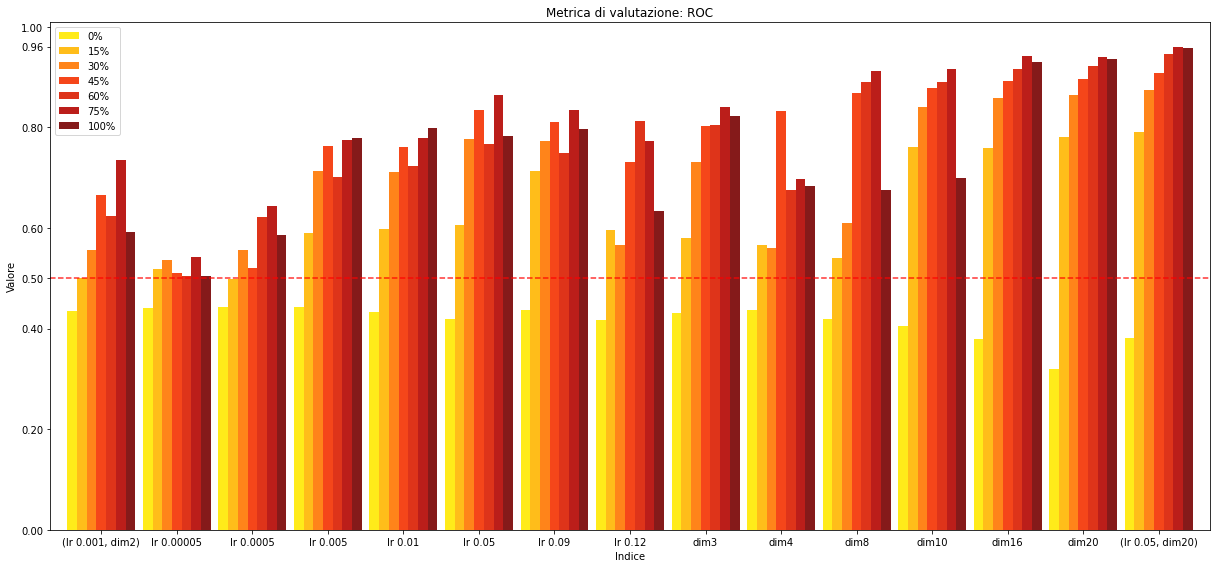

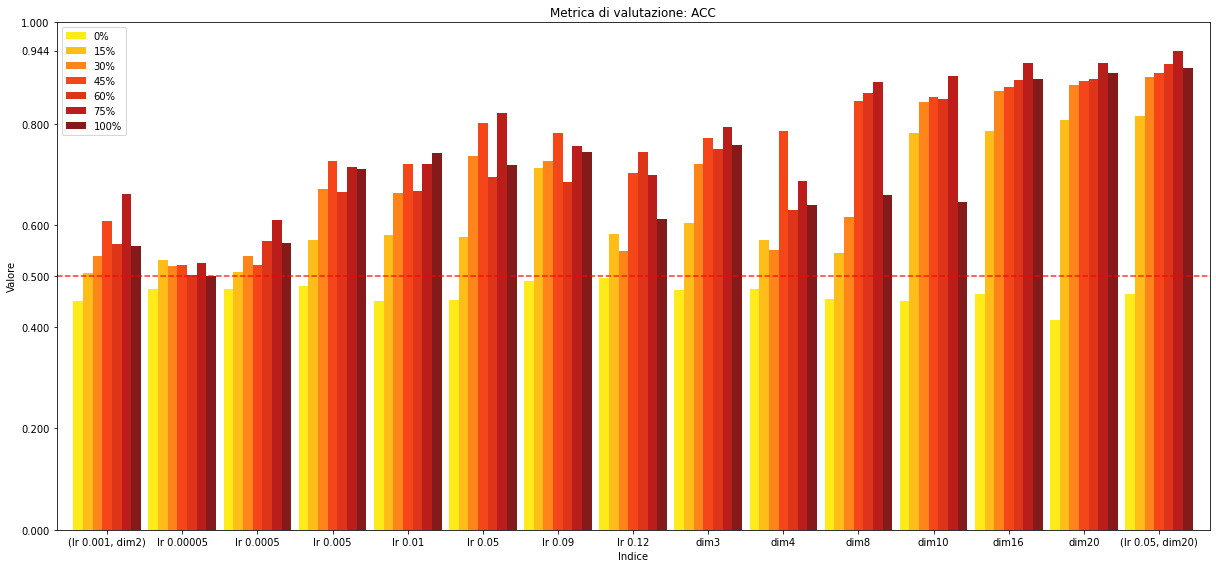

In [3]:
import numpy as np
import matplotlib.pyplot as plt

colors = ["#FFE600", "#FFB300", "#FF7A00", "#F03A00", "#D82600", "#B11200", "#7A0000"]

colors = ["#FFEB1A",  "#FFBD1A",  "#FF841A",  "#F5461A",  "#DE341A",  "#BB1E1A",  "#851A1A"]


data = roc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ROC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

data = acc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ACC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

In [4]:
media_roc = {}
mediana_roc = {}
mode_roc = {}

media_acc = {}
mediana_acc = {}
mode_acc = {}

for key in roc_test.keys():
    media_roc[key] = np.mean(roc_test[key])
    mediana_roc[key] = np.median(roc_test[key])
    mode_roc[key] = np.max(roc_test[key])
    
    media_acc[key] = np.mean(acc_test[key])
    mediana_acc[key] = np.median(acc_test[key])
    mode_acc[key] = np.max(acc_test[key])

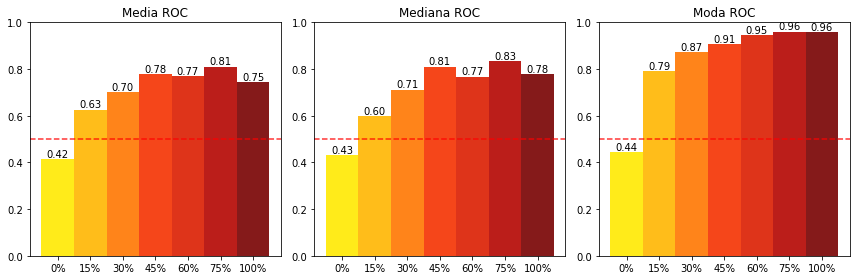

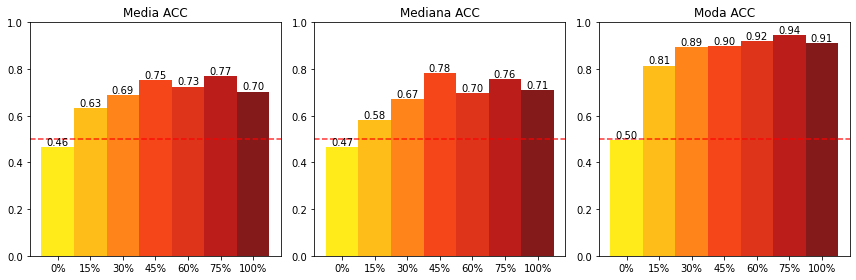

In [5]:
import matplotlib.pyplot as plt
import numpy as np


stampa_barre([media_roc, mediana_roc, mode_roc], steps, "ROC", 4)
stampa_barre([media_acc, mediana_acc, mode_acc], steps, "ACC", 4)

# Albero binario aggiungendo archi gradualmente (1092 archi, 1093 nodi) con GCN

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Cora con GCN e no features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_13_closureGCN"
steps = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1]

roc_test = {}
acc_test = {}

for j in range(len(steps)):
    all_test_roc, all_test_ap = [], []

    for i in range(len(special)):
        folder_path = os.path.join(root_dir + "/" + str(j), str(i))
        embeddings_path = os.path.join(folder_path, "embeddings.npy")
        log = os.path.join(folder_path, "log.txt")

        if not os.path.exists(folder_path):
            print(f"Cartella {folder_path} non trovata, salto.")
            continue

        with open(log, "r") as f:
            cmd = f.readline().strip()

        print(cmd)
        print("\033[1m", special[i], "\033[0m")
        out = print_metrics(log, False)
        print(f"Test roc: {out[4]:.3f}")
        print(f"Test acc: {out[5]:.3f}")

        all_test_roc.append(out[4])
        all_test_ap.append(out[5])

    roc_test[j] = all_test_roc
    acc_test[j] = all_test_ap

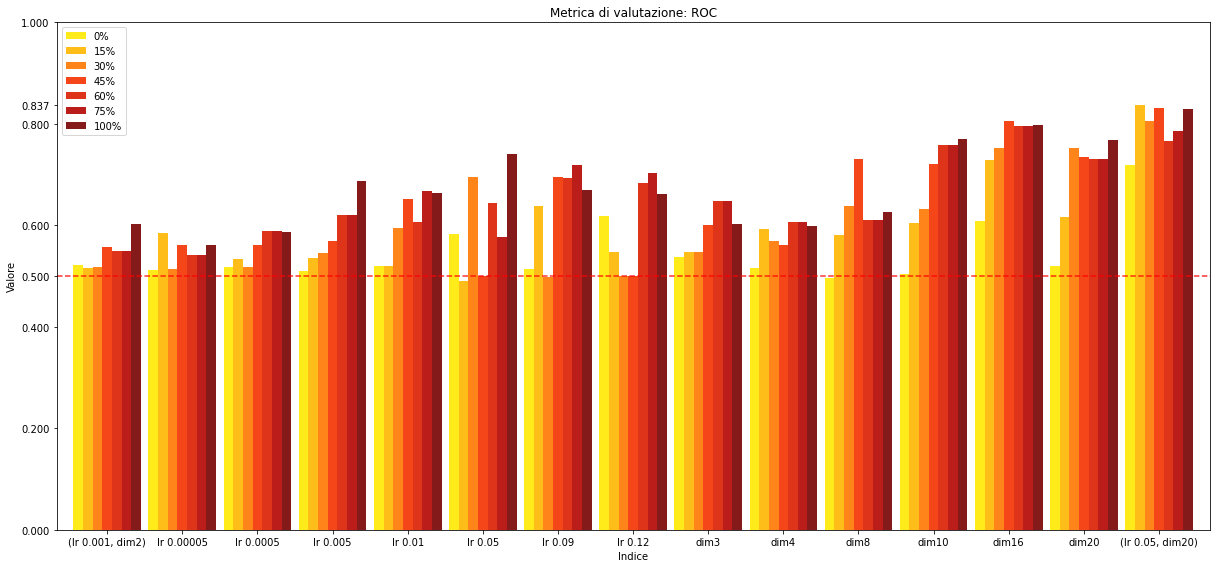

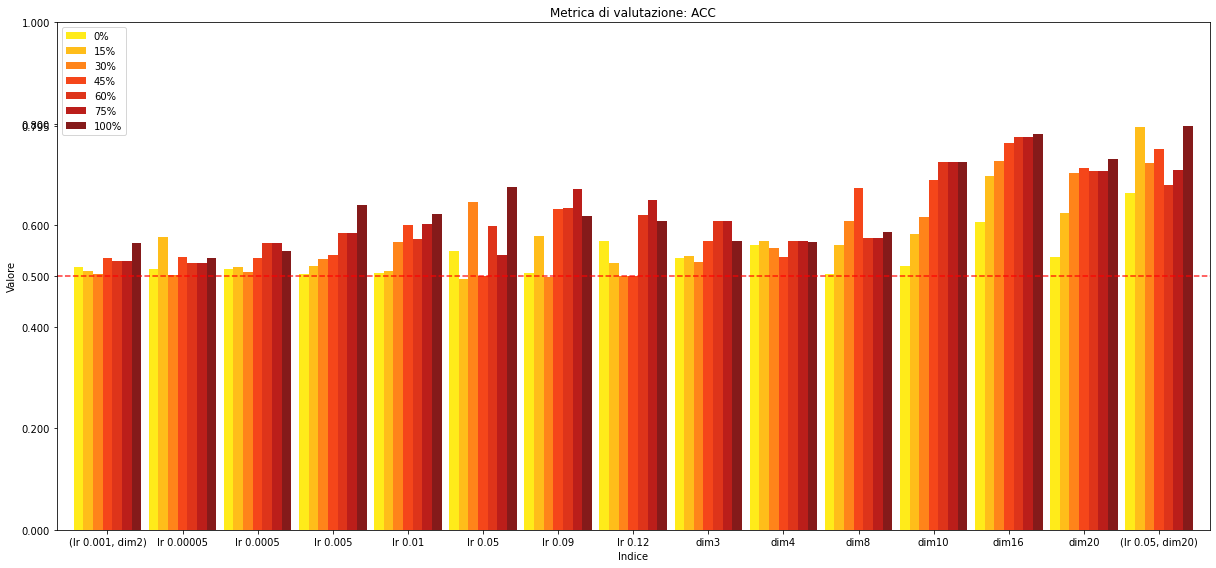

In [7]:
import numpy as np
import matplotlib.pyplot as plt

colors = ["#FFE600", "#FFB300", "#FF7A00", "#F03A00", "#D82600", "#B11200", "#7A0000"]

colors = ["#FFEB1A",  "#FFBD1A",  "#FF841A",  "#F5461A",  "#DE341A",  "#BB1E1A",  "#851A1A"]


data = roc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ROC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

data = acc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ACC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

In [8]:
media_roc = {}
mediana_roc = {}
mode_roc = {}

media_acc = {}
mediana_acc = {}
mode_acc = {}

for key in roc_test.keys():
    media_roc[key] = np.mean(roc_test[key])
    mediana_roc[key] = np.median(roc_test[key])
    mode_roc[key] = np.max(roc_test[key])
    
    media_acc[key] = np.mean(acc_test[key])
    mediana_acc[key] = np.median(acc_test[key])
    mode_acc[key] = np.max(acc_test[key])

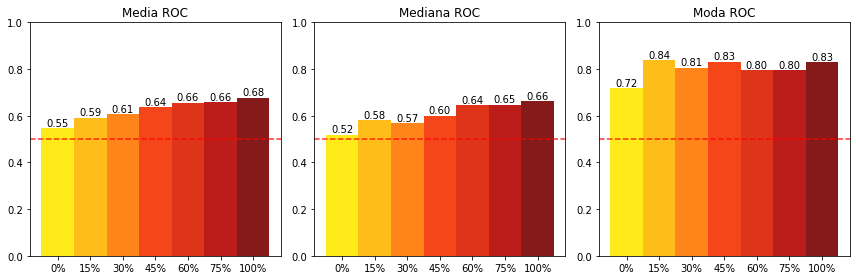

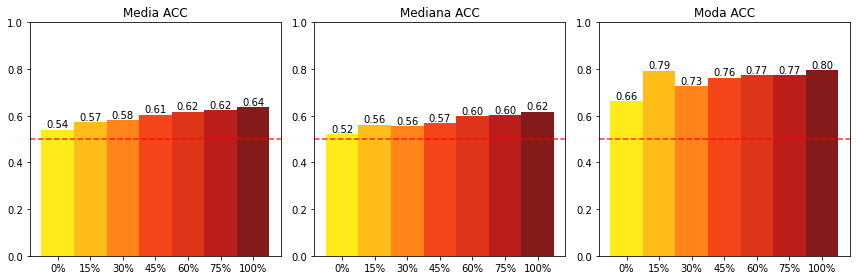

In [9]:
import matplotlib.pyplot as plt
import numpy as np


stampa_barre([media_roc, mediana_roc, mode_roc], steps, "ROC", 4)
stampa_barre([media_acc, mediana_acc, mode_acc], steps, "ACC", 4)

## Stampo gli embeddings dell'albero con 0.75 di chiusura transitiva

lr = 0.001, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 (lr 0.001, dim2) 
Test metrics finali:
  test_loss = 1.2873
  test_roc  = 0.7359
  test_ap   = 0.6609


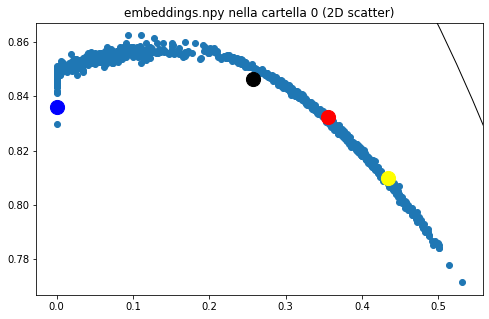

-------------------------------------------------------------------------------------------------------------------
lr = 5e-05, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.00005 
Test metrics finali:
  test_loss = 2.2516
  test_roc  = 0.5431
  test_ap   = 0.5249


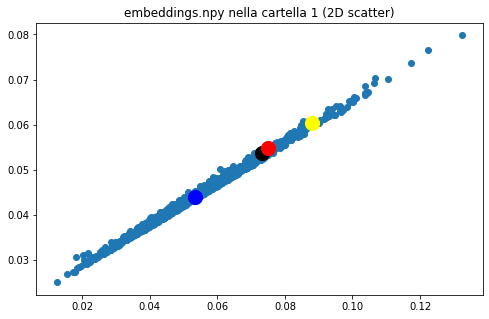

-------------------------------------------------------------------------------------------------------------------
lr = 0.0005, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.0005 
Test metrics finali:
  test_loss = 2.2221
  test_roc  = 0.6433
  test_ap   = 0.6113


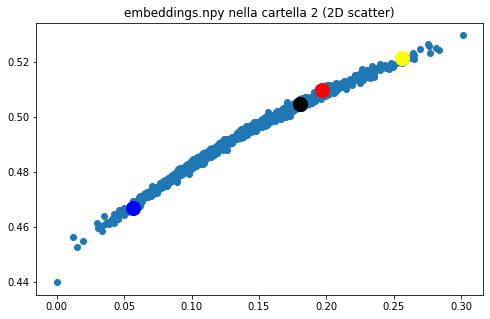

-------------------------------------------------------------------------------------------------------------------
lr = 0.005, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.005 
Test metrics finali:
  test_loss = 1.2234
  test_roc  = 0.7753
  test_ap   = 0.7159


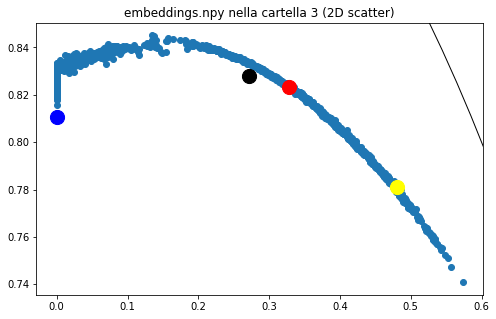

-------------------------------------------------------------------------------------------------------------------
lr = 0.01, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.01 
Test metrics finali:
  test_loss = 1.2342
  test_roc  = 0.778
  test_ap   = 0.7206


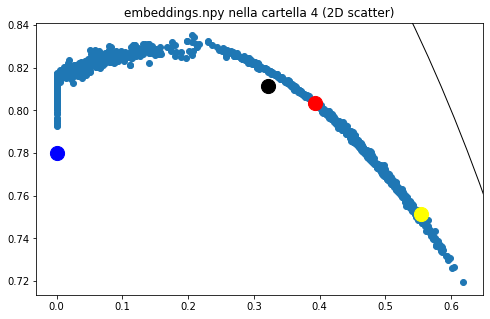

-------------------------------------------------------------------------------------------------------------------
lr = 0.05, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.05 
Test metrics finali:
  test_loss = 0.9217
  test_roc  = 0.8638
  test_ap   = 0.8222


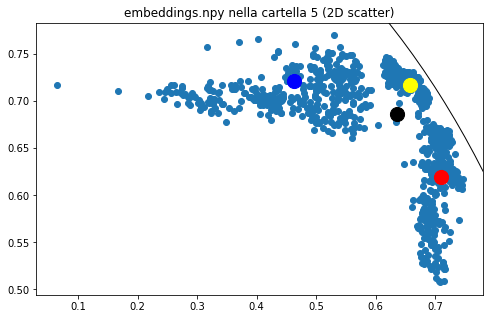

-------------------------------------------------------------------------------------------------------------------
lr = 0.09, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.09 
Test metrics finali:
  test_loss = 0.9289
  test_roc  = 0.8336
  test_ap   = 0.7559


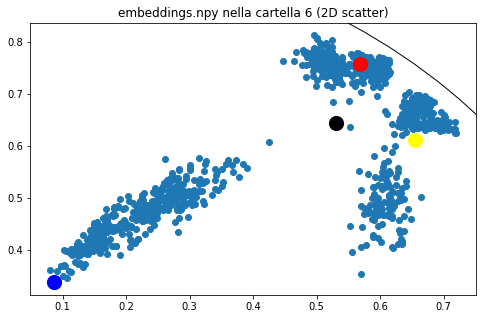

-------------------------------------------------------------------------------------------------------------------
lr = 0.12, model = HGCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 lr 0.12 
Test metrics finali:
  test_loss = 1.2898
  test_roc  = 0.7734
  test_ap   = 0.6985


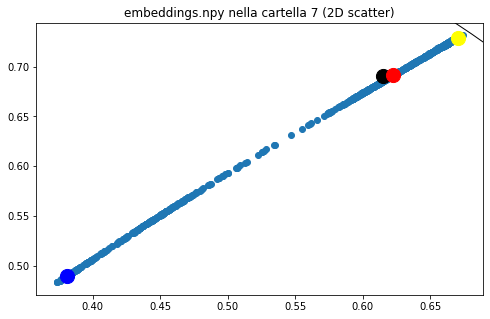

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 3, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim3 
Test metrics finali:
  test_loss = 0.9402
  test_roc  = 0.8413
  test_ap   = 0.7939


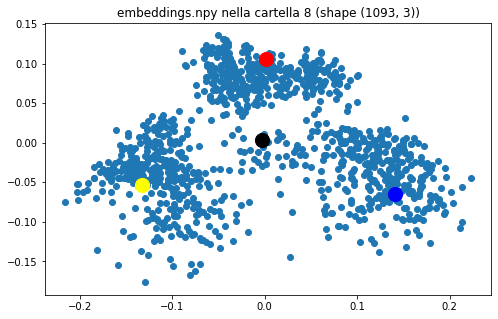

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 4, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim4 
Test metrics finali:
  test_loss = 2.1062
  test_roc  = 0.6971
  test_ap   = 0.6866


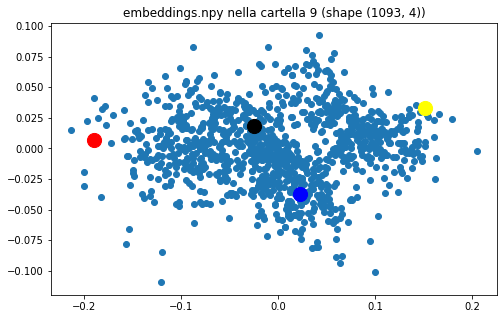

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 8, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim8 
Test metrics finali:
  test_loss = 0.7564
  test_roc  = 0.9114
  test_ap   = 0.882


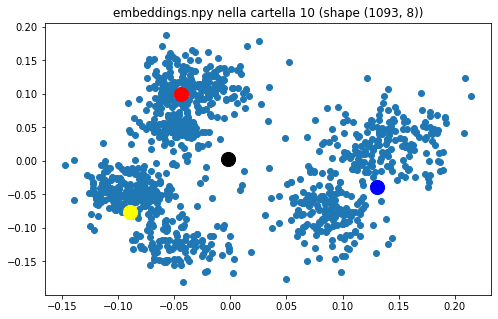

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 10, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim10 
Test metrics finali:
  test_loss = 0.7637
  test_roc  = 0.9151
  test_ap   = 0.8941


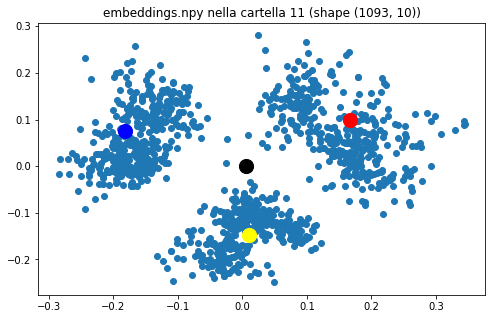

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 16, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim16 
Test metrics finali:
  test_loss = 0.6816
  test_roc  = 0.942
  test_ap   = 0.9195


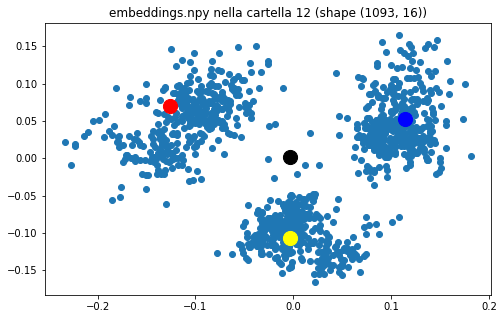

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = HGCN, dropout = 0.2, dim = 20, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 dim20 
Test metrics finali:
  test_loss = 0.6937
  test_roc  = 0.9401
  test_ap   = 0.9201


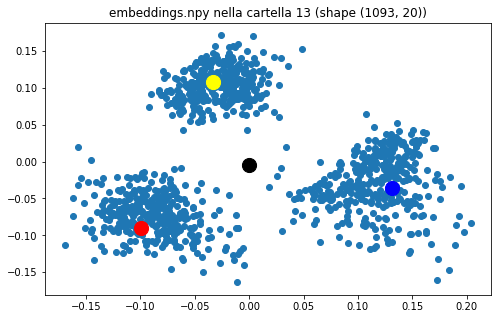

-------------------------------------------------------------------------------------------------------------------
lr = 0.05, model = HGCN, dropout = 0.2, dim = 20, num-layers = 2, c = 1.0, optimizer= RiemannianAdam, weight_decay = 0.0005, manifold = PoincareBall
 (lr 0.05, dim20) 
Test metrics finali:
  test_loss = 0.7346
  test_roc  = 0.9607
  test_ap   = 0.9443


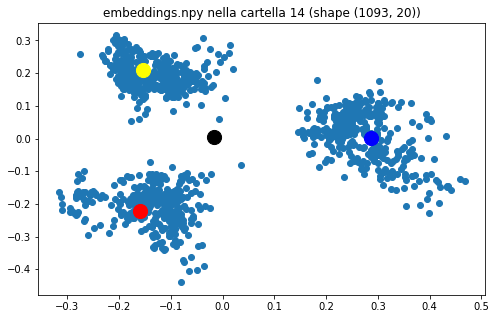

-------------------------------------------------------------------------------------------------------------------


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "WordNet con HGCN senza usare le features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_13_closureHGCN/5"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(special)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.scatter(embeddings[0, 0], embeddings[0, 1], color="black", s=200)
        plt.scatter(embeddings[1, 0], embeddings[1, 1], color="yellow", s=200)
        plt.scatter(embeddings[2, 0], embeddings[2, 1], color="red", s=200)
        plt.scatter(embeddings[3, 0], embeddings[3, 1], color="blue", s=200)
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.scatter(embeddings_pca[0, 0], embeddings_pca[0, 1], color="black", s=200)
        plt.scatter(embeddings_pca[1, 0], embeddings_pca[1, 1], color="yellow", s=200)
        plt.scatter(embeddings_pca[2, 0], embeddings_pca[2, 1], color="red", s=200)
        plt.scatter(embeddings_pca[3, 0], embeddings_pca[3, 1], color="blue", s=200)
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

lr = 0.001, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 (lr 0.001, dim2) 
Test metrics finali:
  test_loss = 2.2539
  test_roc  = 0.5486
  test_ap   = 0.5306


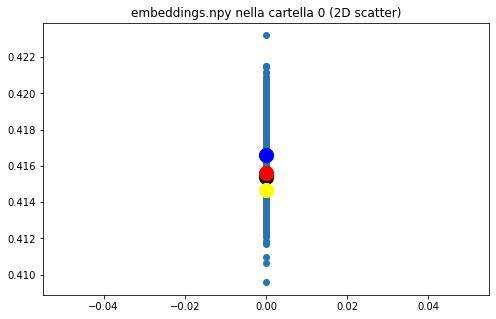

-------------------------------------------------------------------------------------------------------------------
lr = 5e-05, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.00005 
Test metrics finali:
  test_loss = 2.2538
  test_roc  = 0.5425
  test_ap   = 0.5268


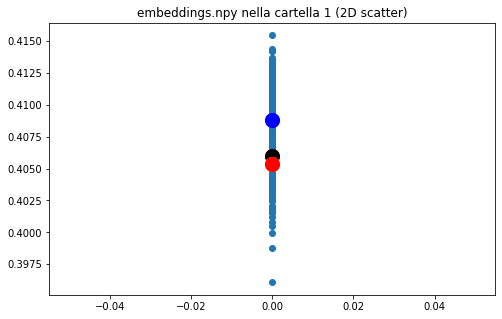

-------------------------------------------------------------------------------------------------------------------
lr = 0.0005, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.0005 
Test metrics finali:
  test_loss = 2.2539
  test_roc  = 0.5898
  test_ap   = 0.5654


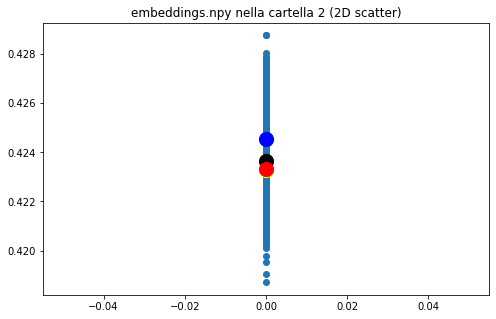

-------------------------------------------------------------------------------------------------------------------
lr = 0.005, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.005 
Test metrics finali:
  test_loss = 2.2538
  test_roc  = 0.6206
  test_ap   = 0.5843


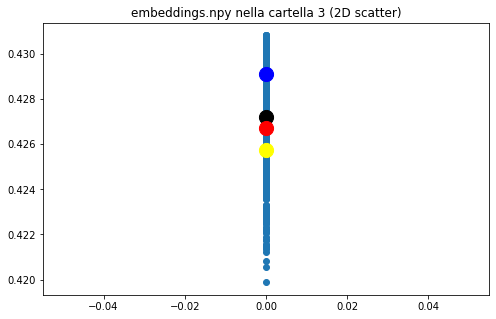

-------------------------------------------------------------------------------------------------------------------
lr = 0.01, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.01 
Test metrics finali:
  test_loss = 2.2539
  test_roc  = 0.6671
  test_ap   = 0.6027


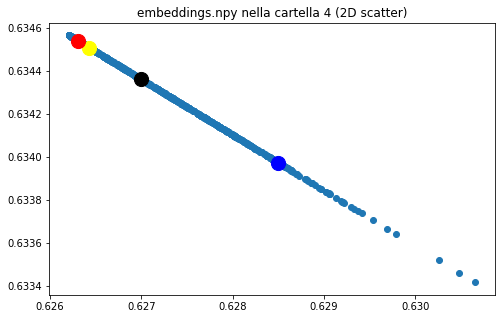

-------------------------------------------------------------------------------------------------------------------
lr = 0.05, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.05 
Test metrics finali:
  test_loss = 2.2539
  test_roc  = 0.5767
  test_ap   = 0.5418


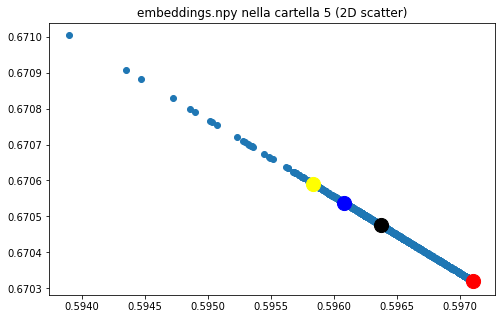

-------------------------------------------------------------------------------------------------------------------
lr = 0.09, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.09 
Test metrics finali:
  test_loss = 2.2502
  test_roc  = 0.7183
  test_ap   = 0.6714


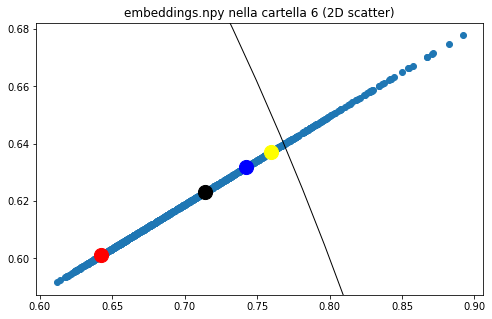

-------------------------------------------------------------------------------------------------------------------
lr = 0.12, model = GCN, dropout = 0.2, dim = 2, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 lr 0.12 
Test metrics finali:
  test_loss = 1.7259
  test_roc  = 0.7029
  test_ap   = 0.6495


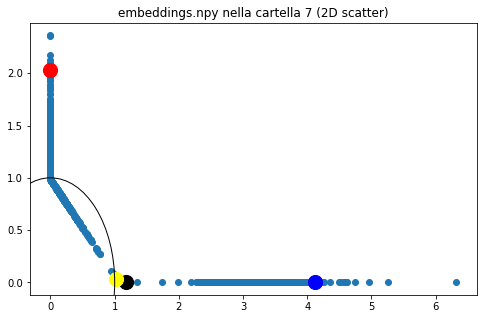

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 3, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim3 
Test metrics finali:
  test_loss = 2.2538
  test_roc  = 0.6476
  test_ap   = 0.6077


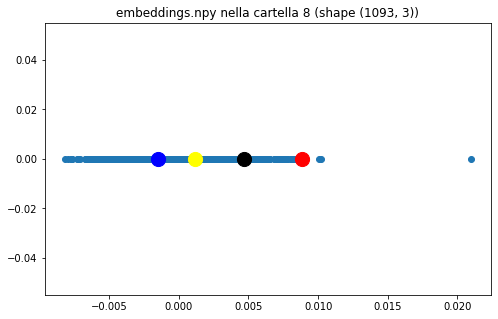

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 4, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim4 
Test metrics finali:
  test_loss = 2.2539
  test_roc  = 0.6065
  test_ap   = 0.5696


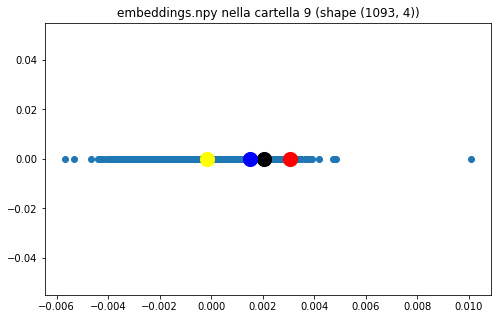

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 8, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim8 
Test metrics finali:
  test_loss = 2.2538
  test_roc  = 0.6096
  test_ap   = 0.5744


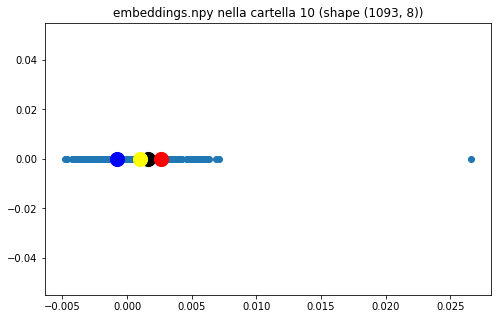

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 10, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim10 
Test metrics finali:
  test_loss = 2.2538
  test_roc  = 0.7574
  test_ap   = 0.7254


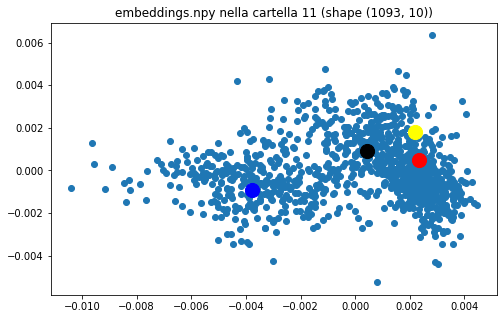

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 16, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim16 
Test metrics finali:
  test_loss = 2.2535
  test_roc  = 0.7956
  test_ap   = 0.7737


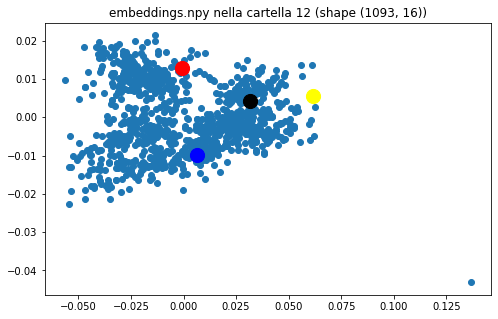

-------------------------------------------------------------------------------------------------------------------
lr = 0.001, model = GCN, dropout = 0.2, dim = 20, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 dim20 
Test metrics finali:
  test_loss = 2.2537
  test_roc  = 0.7313
  test_ap   = 0.7069


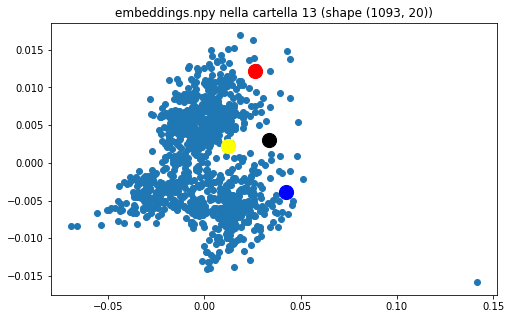

-------------------------------------------------------------------------------------------------------------------
lr = 0.05, model = GCN, dropout = 0.2, dim = 20, num-layers = 2, c = 1.0, optimizer= Adam, weight_decay = 0.0005, manifold = Euclidean
 (lr 0.05, dim20) 
Test metrics finali:
  test_loss = 1.3609
  test_roc  = 0.7865
  test_ap   = 0.7093


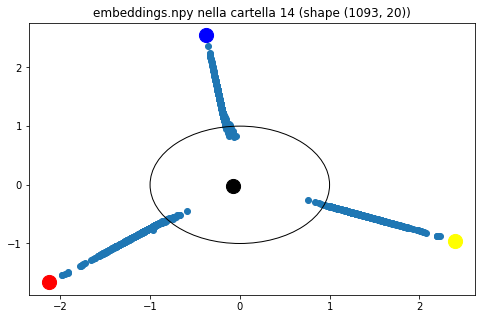

-------------------------------------------------------------------------------------------------------------------


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "WordNet con HGCN senza usare le features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_13_closureGCN/5"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(special)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.scatter(embeddings[0, 0], embeddings[0, 1], color="black", s=200)
        plt.scatter(embeddings[1, 0], embeddings[1, 1], color="yellow", s=200)
        plt.scatter(embeddings[2, 0], embeddings[2, 1], color="red", s=200)
        plt.scatter(embeddings[3, 0], embeddings[3, 1], color="blue", s=200)
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.scatter(embeddings_pca[0, 0], embeddings_pca[0, 1], color="black", s=200)
        plt.scatter(embeddings_pca[1, 0], embeddings_pca[1, 1], color="yellow", s=200)
        plt.scatter(embeddings_pca[2, 0], embeddings_pca[2, 1], color="red", s=200)
        plt.scatter(embeddings_pca[3, 0], embeddings_pca[3, 1], color="blue", s=200)
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

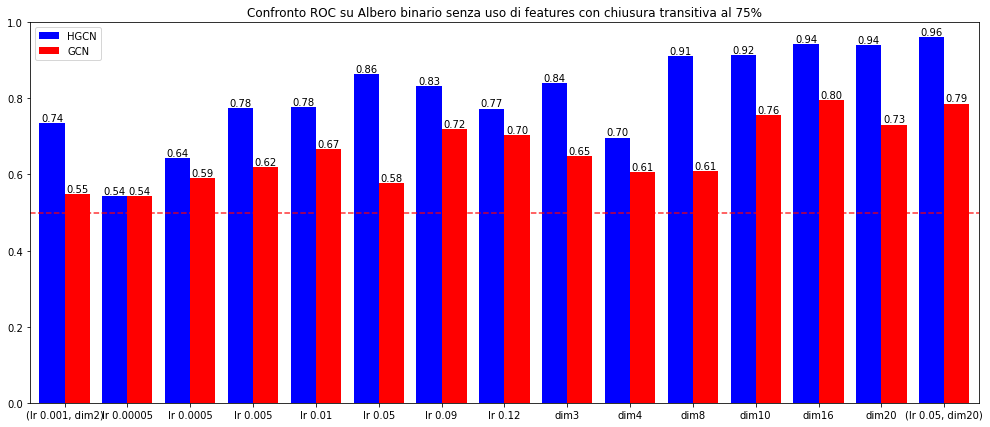

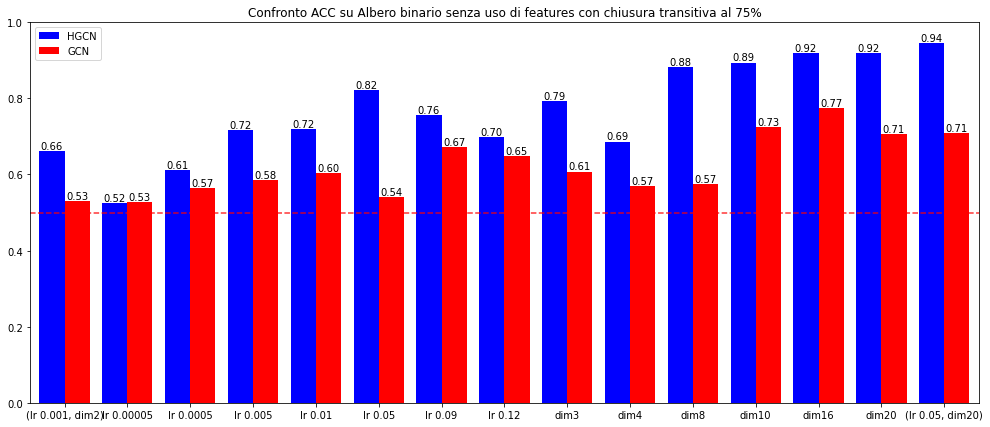

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(special))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC su Albero binario senza uso di features con chiusura transitiva al 75%")

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC su Albero binario senza uso di features con chiusura transitiva al 75%")

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

In [13]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {special[np.argmin(z1)]} ({np.min(z1):.2f})\n-ROC: {special[np.argmin(z2)]} ({np.min(z2):.2f})")
print(f"\nMinor guadagno:\n-ACC: {special[np.argmax(z1)]} ({np.max(z1):.2f})\n-ROC: {special[np.argmax(z2)]} ({np.max(z2):.2f})")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -18.14%
-Su ROC: -17.77%

Maggior guadagno:
-ACC: dim8 (-34.88)
-ROC: lr 0.05 (-33.24)

Minor guadagno:
-ACC: lr 0.00005 (0.36)
-ROC: lr 0.00005 (-0.11)


# Albero binario aggiungendo archi gradualmente (archi 84, nodi 85)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Cora con GCN e no features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_16_closure"
steps = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1]

roc_test = {}
acc_test = {}

for j in range(len(steps)):
    all_test_roc, all_test_ap = [], []

    for i in range(len(special)):
        folder_path = os.path.join(root_dir + "/" + str(j), str(i))
        embeddings_path = os.path.join(folder_path, "embeddings.npy")
        log = os.path.join(folder_path, "log.txt")

        if not os.path.exists(folder_path):
            print(f"Cartella {folder_path} non trovata, salto.")
            continue

        with open(log, "r") as f:
            cmd = f.readline().strip()

        print(cmd)
        print("\033[1m", special[i], "\033[0m")
        out = print_metrics(log, False)
        print(f"Test roc: {out[4]:.3f}")
        print(f"Test acc: {out[5]:.3f}")

        all_test_roc.append(out[4])
        all_test_ap.append(out[5])

    roc_test[j] = all_test_roc
    acc_test[j] = all_test_ap

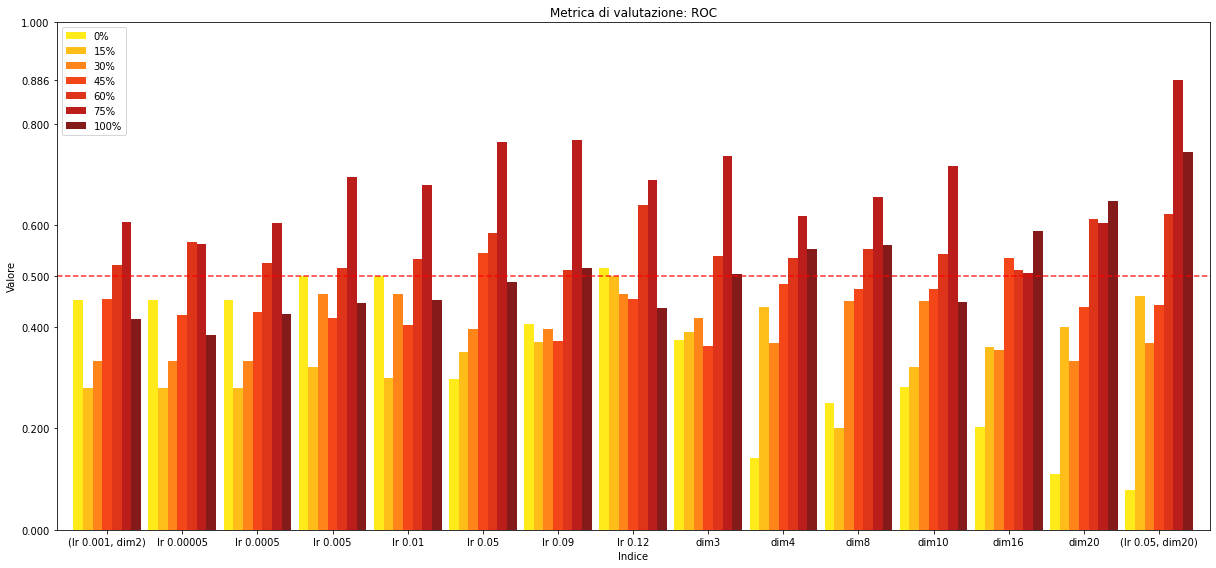

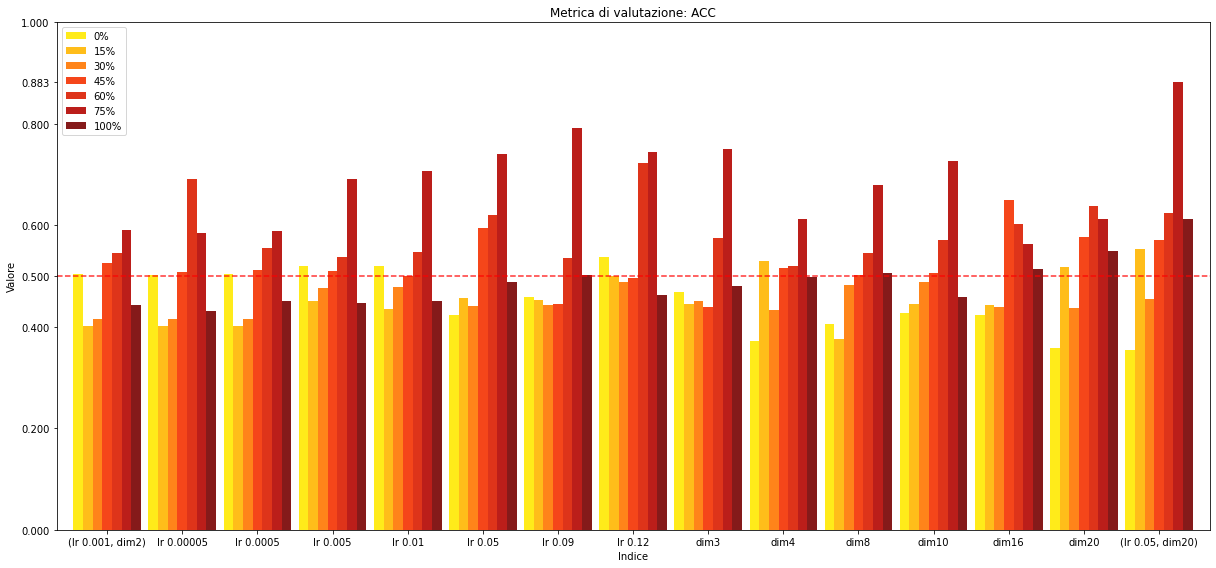

In [15]:
import numpy as np
import matplotlib.pyplot as plt

colors = ["#FFE600", "#FFB300", "#FF7A00", "#F03A00", "#D82600", "#B11200", "#7A0000"]

colors = ["#FFEB1A",  "#FFBD1A",  "#FF841A",  "#F5461A",  "#DE341A",  "#BB1E1A",  "#851A1A"]


data = roc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ROC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

data = acc_test

keys = list(data.keys())
n_keys = len(keys)
n_vals = len(data[keys[0]])

x = np.arange(n_vals)
width = 0.9 / n_keys

plt.figure(figsize=(17, 8))

for i, k in enumerate(keys):
    plt.bar(x + i * width, data[k], width, label=str(int(steps[i]*100))+"%", color = colors[i])

plt.xticks(x + width * (n_keys - 1) / 2, special)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Indice')
plt.ylabel('Valore')
plt.yticks(np.sort([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, np.max(list(data.values()))]))
plt.title("Metrica di valutazione: ACC")
plt.legend()
plt.tight_layout()
plt.margins(x=0.015)
plt.show()

In [16]:
media_roc = {}
mediana_roc = {}
mode_roc = {}

media_acc = {}
mediana_acc = {}
mode_acc = {}

for key in roc_test.keys():
    media_roc[key] = np.mean(roc_test[key])
    mediana_roc[key] = np.median(roc_test[key])
    mode_roc[key] = np.max(roc_test[key])
    
    media_acc[key] = np.mean(acc_test[key])
    mediana_acc[key] = np.median(acc_test[key])
    mode_acc[key] = np.max(acc_test[key])

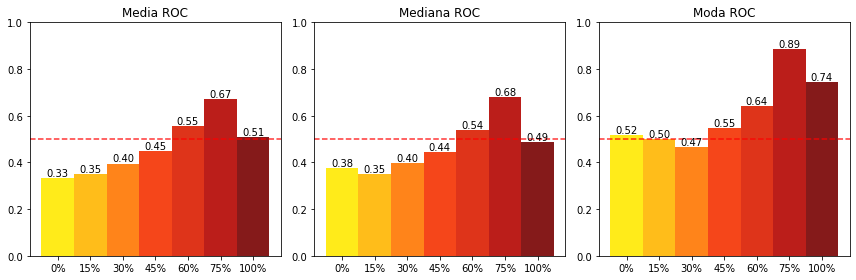

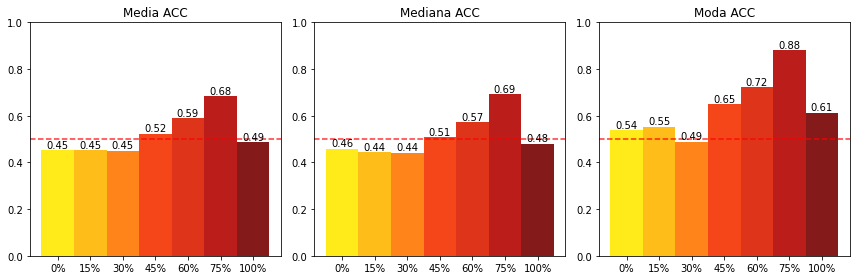

In [17]:
import matplotlib.pyplot as plt
import numpy as np


stampa_barre([media_roc, mediana_roc, mode_roc], steps, "ROC", 4)
stampa_barre([media_acc, mediana_acc, mode_acc], steps, "ACC", 4)